In [2]:
from scipy.special import jn, jn_zeros,jv
d2r=np.pi/180.

In [3]:
def hankel_brute_force(l=[],theta=[],cl12=[],j_nu=0): 
#only auto covariance. cl12 and l should have same shape, i.e. cl12 is not a matrix but a vector.
#we transform like eq. 34 in https://arxiv.org/pdf/0708.0387.pdf .
    J=jn(j_nu,np.outer(theta,l))
    dl=np.gradient(l)
    cov=np.dot(J,(J*cl12*l*dl).T)
    cov/=2*np.pi
    return cov

#more basic binning code for testing.
def bin_cov(r=[],cov=[],r_bins=[]):
    bin_center=0.5*(r_bins[1:]+r_bins[:-1])
    n_bins=len(bin_center)
    cov_int=np.zeros((n_bins,n_bins),dtype='float64')
    bin_idx=np.digitize(r,r_bins)-1
    r2=np.sort(np.unique(np.append(r,r_bins))) #this takes care of problems around bin edges
    dr=np.gradient(r2)
    r2_idx=[i for i in np.arange(len(r2)) if r2[i] in r]
    dr=dr[r2_idx]
    r_dr=r*dr
    cov_r_dr=cov*np.outer(r_dr,r_dr)
    for i in np.arange(min(bin_idx+1),n_bins):
        xi=bin_idx==i
        for j in np.arange(min(bin_idx),n_bins):
            xj=bin_idx==j
            norm_ij=np.sum(r_dr[xi])*np.sum(r_dr[xj])
#             if i==j:
#                 print( i,j,norm_ij)
            if norm_ij==0:
                continue
            cov_int[i][j]=np.sum(cov_r_dr[xi,:][:,xj])/norm_ij
    #cov_int=np.nan_to_num(cov_int)
#         print np.diag(cov_r_dr)
    return cov_int

In [4]:
n_gal=1.496 #DES first bin
area= 5000.0
sigma_e= 0.39441348451  
sigma_gamma=sigma_e/np.sqrt(2)
th_min=2.5/60
th_max=250./60
n_th_bins=20

In [5]:
n_gal_rad=n_gal*60.*60./d2r**2
SN=sigma_e**2/2/n_gal_rad

f_sky=area/(4*np.pi/d2r**2)

ell_max=1.e4
ell=np.arange(ell_max)+1

th_bins=np.logspace(np.log10(th_min),np.log10(th_max),n_th_bins+1)
th=np.logspace(np.log10(th_min),np.log10(th_max),n_th_bins*30)
thb=0.5*(th_bins[1:]+th_bins[:-1])

In [6]:
area_rad=4*np.pi*f_sky

In [7]:
SN2=SN**2*np.ones_like(ell)

cov_th=hankel_brute_force(l=ell,theta=th*d2r,cl12=SN2,j_nu=4)
cov_th/=area_rad

cov_th*=2 #this is auto covariance, hence we have 2 terms, C1324 abd C1423. 
            #This is the reason by Joachimi+2007 have pi in denominators of eq. 34 and not 2pi.

cov_th_binned=bin_cov(r=th,cov=cov_th,r_bins=th_bins)

In [8]:
#using direct expression from Joachimi+ for real space
N1=2*np.pi*area_rad*n_gal_rad**2 #area and number density in the normalization

N1*=2 #factor of 2 missing in Joachimi's paper? definition of Np above eq. 34.

dthb=th_bins[1:]-th_bins[:-1]
N2=(thb*dthb*d2r**2) #**2  #bin volume in the normalization
# N2/=thb*dthb*d2r**2 #bin volume in the numerator.

SN_diag=sigma_e**4/N1/N2
# SN_diag=1./N1/N2

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


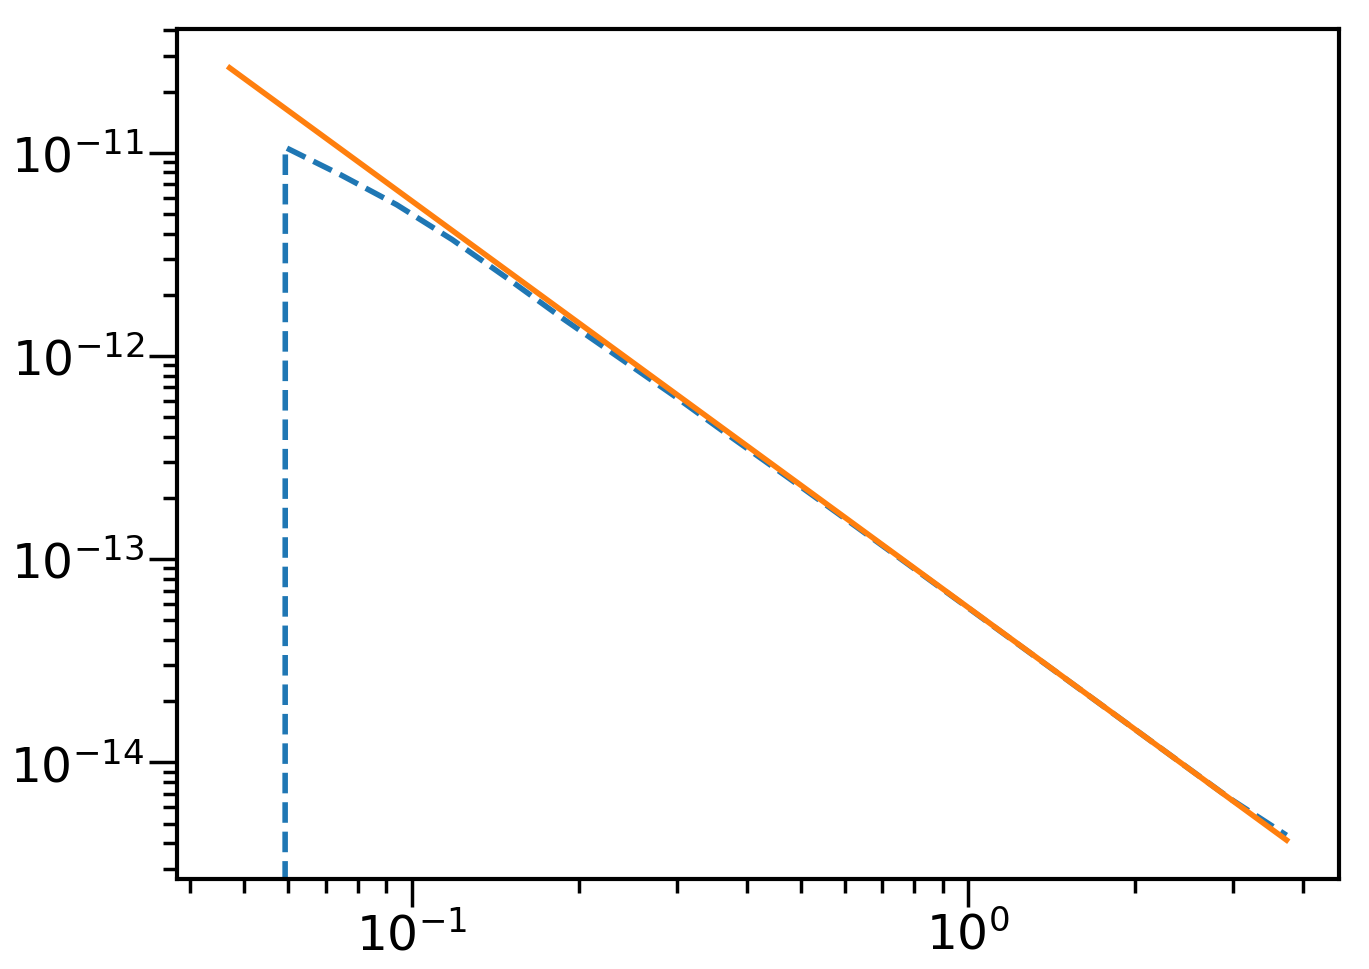

In [10]:
plot(thb,np.diag(cov_th_binned),'--')
plot(thb,SN_diag)
xscale('log')
yscale('log')

In [68]:
test_binned=bin_cov(r=th,cov=1./th#np.diag(np.ones_like(th))
                    ,r_bins=th_bins)

In [69]:
np.diag(test_binned)

array([ 0.        , 16.89437805, 13.41838165, 10.65756712,  8.46478665,
        6.72316795,  5.33988505,  4.24121082,  3.36858737,  2.67550506,
        2.12502352,  1.68780282,  1.3405397 ,  1.0647255 ,  0.8456597 ,
        0.6716664 ,  0.53347197,  0.42371087,  0.33653295,  0.26758007])

In [61]:
cd=np.diag(cov_th)
corr=cov_th/(np.sqrt(np.outer(cd,cd)))

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


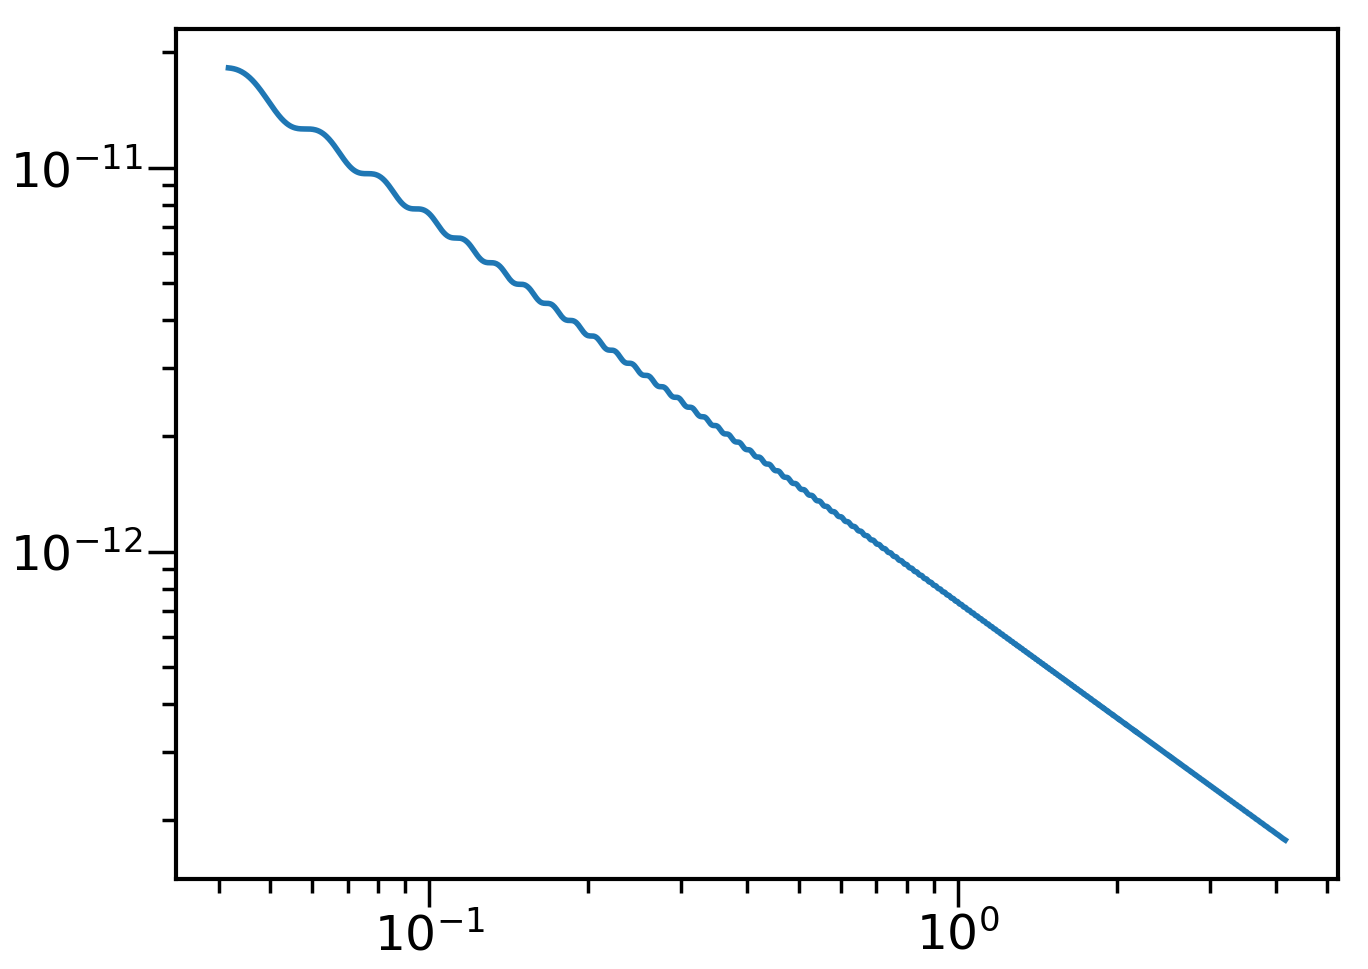

In [67]:
plot(th,cd)
xscale('log')
yscale('log')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


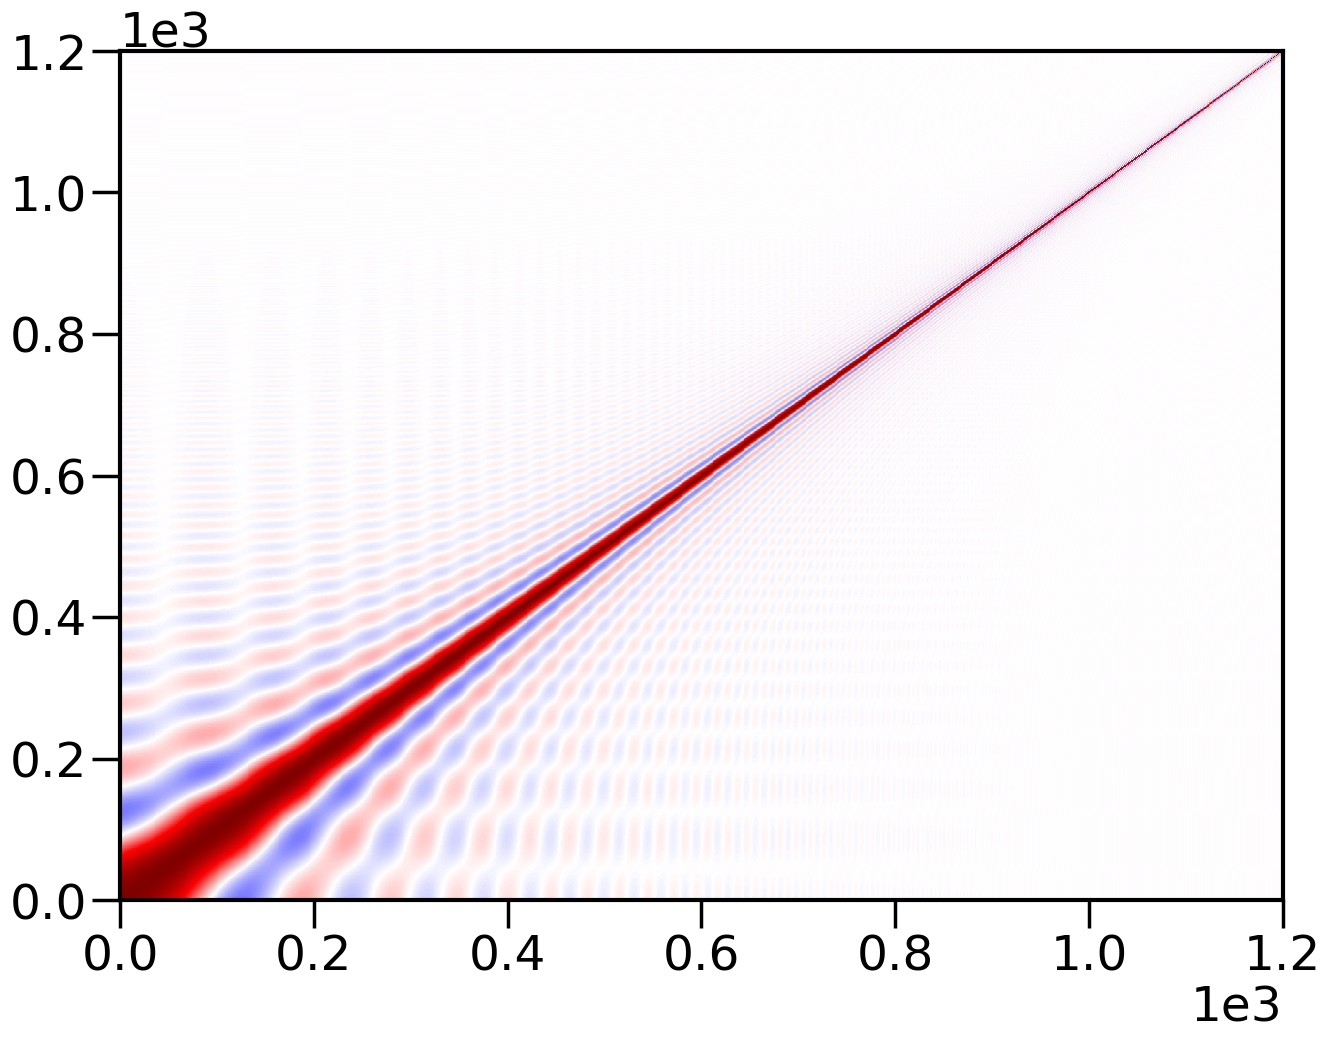

In [63]:
pcolor(corr,vmin=-1,vmax=1,cmap='seismic')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


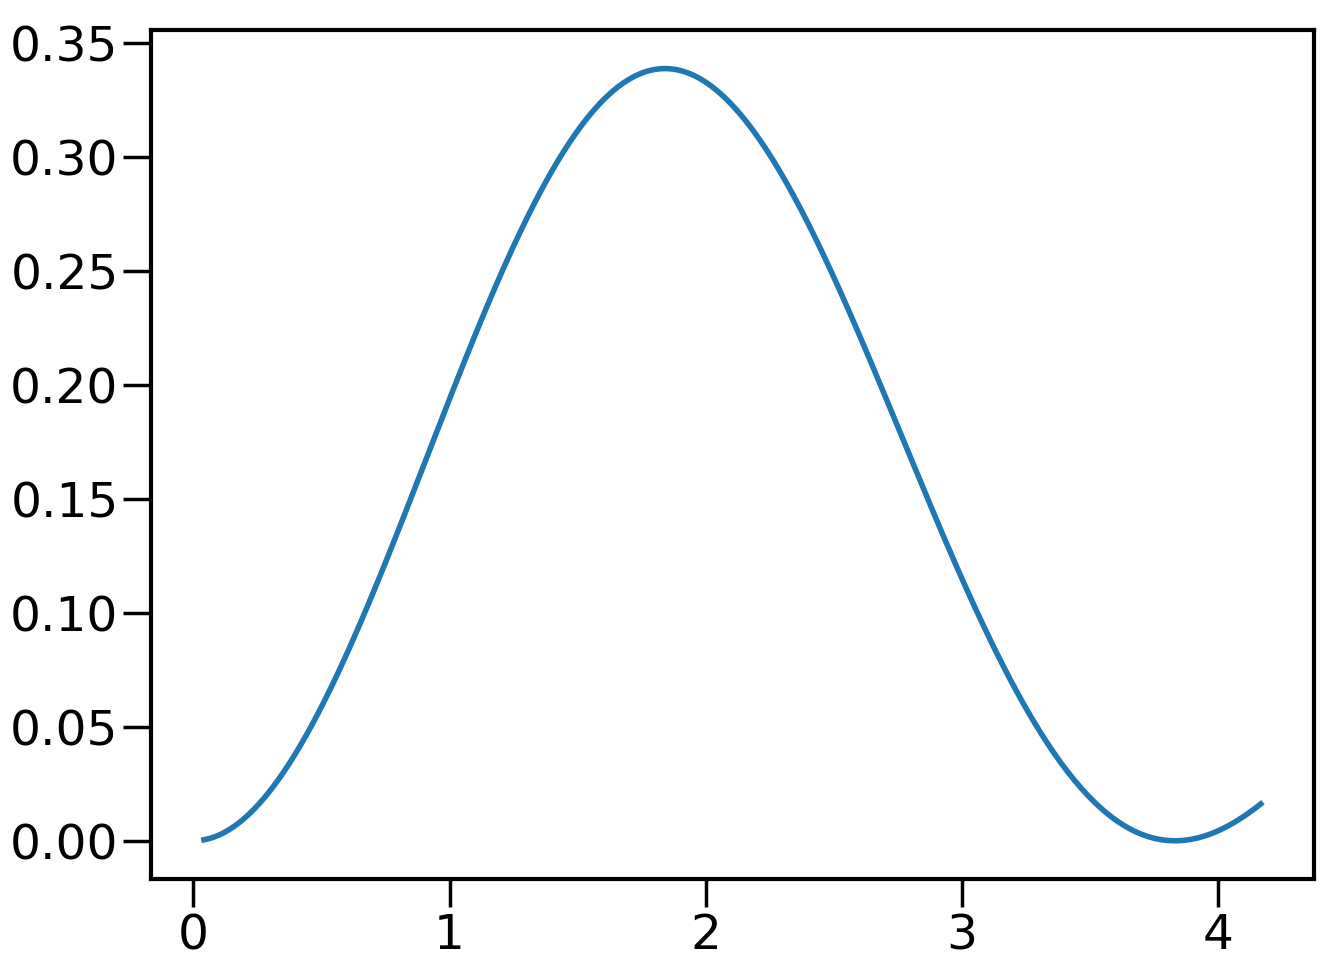

In [66]:
plot(th,jn(1,th)**2)